In [1]:
import warnings
from unicodedata import normalize

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tools as fc

**Configuraciones**


In [2]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
title_data = 'Materiales extraidos en Colombia'
warnings.filterwarnings("ignore")

**Data**

In [3]:
url_master =  'https://drive.google.com/uc?id=' 
url_minero='https://drive.google.com/file/d/10_YGM_dOKzzLsLNkfB_bN5YeLgDHcrUZ/view?usp=sharing'
url_department = 'https://drive.google.com/file/d/1fKM6yk_oxEsjJyZhOsSjmdcryN7Y50RK/view?usp=sharing'
url_type_miner = 'https://drive.google.com/file/d/1Q69MPSg8joI1nZz6CYwxa0_DdUGquRU2/view?usp=sharing'

url_minero =  url_master + url_minero.split('/')[-2]
url_department =  url_master + url_department.split('/')[-2]
url_type_miner =  url_master + url_type_miner.split('/')[-2]


data_miner = pd.read_csv(url_minero, dtype=str)
data_department = pd.read_csv(url_department, dtype=str)
data_type_miner = pd.read_csv(url_type_miner, dtype=str)

In [4]:
data_miner.columns =[
        'city',
        'state',
        'natural_resource',
        'name_project',
        'year_exploitation',
        'quarter',
        'unit_measurement',
        'type_compensation',
        'value_compensation',
        'production_quantity'
    ]

In [5]:
data_department.columns = [
    'code_state',
    'code_city',
    'state',
    'city',
    'region',
    'access_sea'
]

In [6]:
data_type_miner.columns = [
    'natural_resource',
    'first_clasification',
    'second_clasification',
]

In [7]:
data_miner.head(1)

,city,state,natural_resource,name_project,year_exploitation,quarter,unit_measurement,type_compensation,value_compensation,production_quantity
0,Medellin,Antioquia,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,614258,0


In [8]:
data_department.head(1)

,code_state,code_city,state,city,region,access_sea
0,5,5001,ANTIOQUIA,MEDELLÍN,Andina,Si


In [9]:
data_type_miner.head(1)

,natural_resource,first_clasification,second_clasification
0,ARCILLAS,Rocas sedimentarias,NaN


**Data Processing**



must have consistency in the fields jurisdiction in all tables. that's why  they are  convert the values in upper and without accent

In [10]:
data_miner['city'] = data_miner['city'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

data_miner['state'] = data_miner['state'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

data_department[
    'state'] = data_department['state'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

data_department[
    'city'] = data_department['city'].apply(
    lambda x: normalize('NFKD', x.upper()).encode('ASCII', 'ignore').decode() 
)

Normalization of names of the columns

In [11]:
columns = fc.normalize_name_columns(data_miner.columns)
data_miner.columns = columns

columns = fc.normalize_name_columns(data_department.columns)
data_department.columns = columns

columns = fc.normalize_name_columns(data_type_miner.columns)
data_type_miner.columns = columns

change the type of columns, since, all types the features  are object

In [12]:
data_miner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55257 entries, 0 to 55256
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 55257 non-null  object
 1   state                55257 non-null  object
 2   natural_resource     55257 non-null  object
 3   name_project         55257 non-null  object
 4   year_exploitation    55257 non-null  object
 5   quarter              55257 non-null  object
 6   unit_measurement     55257 non-null  object
 7   type_compensation    55257 non-null  object
 8   value_compensation   55257 non-null  object
 9   production_quantity  55257 non-null  object
dtypes: object(10)
memory usage: 4.2+ MB


In [13]:
data_miner[[
    'value_compensation',
    'production_quantity']] = data_miner[[
    'value_compensation',
    'production_quantity']].astype('float64')
data_miner[
    'year_exploitation'] = data_miner[
    'year_exploitation'].astype('int64')

Joiner the tables

In [14]:
data_processing = pd.merge(
    data_miner, 
    data_department, 
    on=['city', 'state'], 
    how='left').drop(
        columns=[
            'code_state',
        ]
    ).drop(columns=['access_sea'])

In [15]:
data_miner.columns

Index(['city', 'state', 'natural_resource', 'name_project',
       'year_exploitation', 'quarter', 'unit_measurement', 'type_compensation',
       'value_compensation', 'production_quantity'],
      dtype='object')

In [16]:
data_processing = pd.merge(
    data_processing,
    data_type_miner,
    left_on=['natural_resource'],
    right_on=['natural_resource'],
    how='left'
)

In [17]:
data_processing.shape

(55257, 14)

In [18]:
data_processing.head(1)

,city,state,natural_resource,name_project,year_exploitation,quarter,unit_measurement,type_compensation,value_compensation,production_quantity,code_city,region,first_clasification,second_clasification
0,MEDELLIN,ANTIOQUIA,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,"614,258.00",0.00,5001,Andina,Rocas sedimentarias,NaN


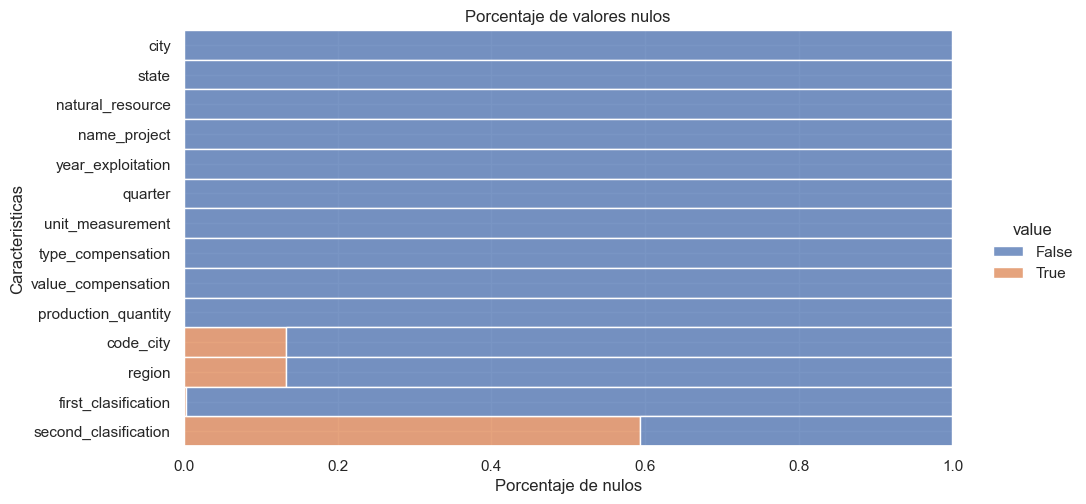

In [19]:
fc.porcentaje_nulos_x_caracteristica(
    data_processing, 
    title="Porcentaje de valores nulos", 
    xlabel='Porcentaje de nulos', 
    ylabel='Caracteristicas')

- There approximately 15% data null in the features code_city and region
- There approximately 58% data null in the features in second_clasification
- There are rows nulls because the keys of data of classification resource no exist in  main data

In [20]:
data_processing['year_exploitation'].value_counts().index.sort_values()

Index([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], dtype='int64', name='year_exploitation')

- There is data from 2012 to 2023, 11 year

In [21]:
data_processing['state'].value_counts().index

Index(['ANTIOQUIA', 'BOYACA', 'CHOCO', 'CUNDINAMARCA', 'TOLIMA', 'SANTANDER',
       'CAUCA', 'CALDAS', 'BOLIVAR', 'NORTE DE SANTANDER', 'VALLE DEL CAUCA',
       'CESAR', 'HUILA', 'NARINO', 'CORDOBA', 'LA GUAJIRA', 'META',
       'RISARALDA', 'ATLANTICO', 'CASANARE', 'MAGDALENA', 'BOGOTA, D.C.',
       'PUTUMAYO', 'CAQUETA', 'SUCRE', 'QUINDIO', 'ARAUCA', 'GUAINIA',
       'GUAVIARE', 'VICHADA', 'VAUPES', 'AMAZONAS'],
      dtype='object', name='state')

In [22]:
len(data_processing['state'].value_counts().index)

32

- There are 32 states in dataset of Colombia

In [23]:
data_processing['natural_resource'].value_counts().index

Index(['ORO', 'PLATA', 'GRAVAS', 'CARBON', 'ARENAS', 'RECEBO', 'CALIZAS',
       'PLATINO', 'ARCILLAS MISCELANEAS', 'GRAVAS DE RIO', 'ARENA DE RIO',
       'ARCILLAS CERAMICAS', 'GRAVA DE CANTERA', 'ARENA DE CANTERA',
       'ARCILLAS', 'ARENAS SILICEAS', 'ESMERALDAS TALLADAS', 'YESO',
       'ESMERALDAS EN BRUTO', 'HIERRO', 'NIQUEL', 'DIABASA', 'ROCA FOSFORICA',
       'ARCILLAS FERRUGINOSAS', 'MARMOL EN RAJON (RETAL DE MÁRMOL)', 'SAL',
       'GRAVAs DE RIO', 'ARCILLAS CAOLINITICA', 'DOLOMITA', 'ASFALTITA',
       'MARMOL', 'PUZOLANAS', 'ESMERALDAS', 'ESMERALDAS SEMIPRECIOSA',
       'BASALTO', 'COBRE', 'MARMOL EN RAJÓN (RETAL DE MÁRMOL)', 'FELDESPATOS',
       'ESMERALDAS ENGASTADA', 'MARMOL (BLOQUE MAYOR O IGUAL A 1 M3)',
       'ARCILLAS BENTONITICA', 'BARITA', 'TALCO',
       'MARMOL (BLOQUE MENOR A 1 M3)', 'SERPENTINA (SILICATO DE MAGNESIO)',
       'MANGANESO', 'MINERAL DE MAGNESIO (MAGNESITA)',
       'TRAVERTINO Y CALIZAS CRISTALINAS EN BLOQUE MAYOR O IGUAL A 1 M3',
       'B

In [24]:
len(data_processing['natural_resource'].value_counts().index)

73

- There are 73 natural resource in dataset of Colombia

In [25]:
data_processing

,city,state,natural_resource,name_project,year_exploitation,quarter,unit_measurement,type_compensation,value_compensation,production_quantity,code_city,region,first_clasification,second_clasification
0,MEDELLIN,ANTIOQUIA,ARCILLAS,PRODUCTORES,2018,Trimestre 4,TONELADAS,REGALIAS,"614,258.00",0.00,5001,Andina,Rocas sedimentarias,NaN
1,MEDELLIN,ANTIOQUIA,ARCILLAS CERAMICAS,PRODUCTORES,2014,Trimestre 4,TONELADAS,REGALIAS,"2,036,781.00","14,381.00",5001,Andina,Rocas sedimentarias,NaN
2,MEDELLIN,ANTIOQUIA,ARCILLAS FERRUGINOSAS,PRODUCTORES,2012,Trimestre 1,TONELADAS,REGALIAS,"836,927.00","16,308.00",5001,Andina,Rocas sedimentarias,NaN
3,MEDELLIN,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2019,Trimestre 1,TONELADAS,REGALIAS,"5,763,839.00","33,348.00",5001,Andina,Rocas sedimentarias,NaN
4,MEDELLIN,ANTIOQUIA,ARCILLAS MISCELANEAS,PRODUCTORES,2022,Trimestre 1,TONELADAS,REGALIAS,"7,187,998.00","28,540.00",5001,Andina,Rocas sedimentarias,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55252,CUMARIBO,VICHADA,TANTALIO,PRODUCTORES,2018,Trimestre 2,KILOGRAMOS,REGALIAS,"645,095.00",35.00,99773,Orinoquía,Metal,Metal de transicion
55253,CUMARIBO,VICHADA,ORO,PRODUCTORES,2019,Trimestre 4,GRAMOS,REGALIAS,"9,251,843.00","1,752.00",99773,Orinoquía,Metal,Metal de transicion
55254,CUMARIBO,VICHADA,NIOBIO,PRODUCTORES,2014,Trimestre 4,KILOGRAMOS,REGALIAS,"23,396,026.00","6,195.00",99773,Orinoquía,Metal,Metal de transicion
55255,CUMARIBO,VICHADA,NIOBIO,PRODUCTORES,2016,Trimestre 4,KILOGRAMOS,REGALIAS,"12,658,396.00","1,442.00",99773,Orinoquía,Metal,Metal de transicion


In [26]:
data_processing['natural_resource'].value_counts().index

Index(['ORO', 'PLATA', 'GRAVAS', 'CARBON', 'ARENAS', 'RECEBO', 'CALIZAS',
       'PLATINO', 'ARCILLAS MISCELANEAS', 'GRAVAS DE RIO', 'ARENA DE RIO',
       'ARCILLAS CERAMICAS', 'GRAVA DE CANTERA', 'ARENA DE CANTERA',
       'ARCILLAS', 'ARENAS SILICEAS', 'ESMERALDAS TALLADAS', 'YESO',
       'ESMERALDAS EN BRUTO', 'HIERRO', 'NIQUEL', 'DIABASA', 'ROCA FOSFORICA',
       'ARCILLAS FERRUGINOSAS', 'MARMOL EN RAJON (RETAL DE MÁRMOL)', 'SAL',
       'GRAVAs DE RIO', 'ARCILLAS CAOLINITICA', 'DOLOMITA', 'ASFALTITA',
       'MARMOL', 'PUZOLANAS', 'ESMERALDAS', 'ESMERALDAS SEMIPRECIOSA',
       'BASALTO', 'COBRE', 'MARMOL EN RAJÓN (RETAL DE MÁRMOL)', 'FELDESPATOS',
       'ESMERALDAS ENGASTADA', 'MARMOL (BLOQUE MAYOR O IGUAL A 1 M3)',
       'ARCILLAS BENTONITICA', 'BARITA', 'TALCO',
       'MARMOL (BLOQUE MENOR A 1 M3)', 'SERPENTINA (SILICATO DE MAGNESIO)',
       'MANGANESO', 'MINERAL DE MAGNESIO (MAGNESITA)',
       'TRAVERTINO Y CALIZAS CRISTALINAS EN BLOQUE MAYOR O IGUAL A 1 M3',
       'B

In [27]:
data_processing.columns

Index(['city', 'state', 'natural_resource', 'name_project',
       'year_exploitation', 'quarter', 'unit_measurement', 'type_compensation',
       'value_compensation', 'production_quantity', 'code_city', 'region',
       'first_clasification', 'second_clasification'],
      dtype='object')

In [28]:
data_processing['name_project'].value_counts().index

Index(['PRODUCTORES', 'MINAS PAZ DEL RIO S.A.', 'Cerro Matoso S.A.',
       'PRODECO - CALENTURITAS', 'Drummond - El Descanso',
       'Drummond - La Loma', 'CERREJON CONTRATO DE ASOCIACION',
       'CERREJON  CZN - CEMT', 'CERREJON -  OREGANAL',
       'CARBONES DEL CERREJON COMUNIDAD - RPP', 'COLSALMINAS LTDA',
       'CERREJON - PATILLA', 'CONSORCIO MINERO UNIDO S.A.', 'EL HATILLO CNR',
       'CARBONES DE LA JAGUA S.A.', 'BRINSA S.A.', 'CNR - LA FRANCIA',
       'CARBONES EL TESORO', 'Drummond - El Corozo', 'NORCARBON',
       'SALCOL S.A.', 'SALINAS DE GALERAS SAS',
       'CARBONES DEL CERREJON COMUNIDAD - RPP CAYPA',
       'BIG GROUP SALINAS COLOMBIA - MANAURE', 'ACERIAS PAZ DEL RIO',
       'HOLCIM (COLOMBIA) S A'],
      dtype='object', name='name_project')

In [29]:
len(data_processing['name_project'].value_counts().index)

26

There are 26 natural resource exploitation projects in dataset of Colombia

`The years 2020, 2021, 2022 are selected of data to process. The two quarter of 2023, is will useding for validation`

In [30]:
data_processing = data_processing[
    (data_processing['year_exploitation'] > 2019)
    &
    (data_processing['year_exploitation'] < 2023)
]

**Transactions**

In [31]:
function_dictionary = {
    'value_compensation':['sum', 'count']
}

data_transaction = data_processing.groupby([
    'city',
    'state',
    'year_exploitation',
    'quarter'
]).aggregate(
    function_dictionary
)

data_transaction.columns = [
    'sum_value_compensation',
    'count_n_transactions'
]

data_transaction.reset_index(inplace=True)


function_dictionary = {
    'sum_value_compensation':['sum', 'mean', 'median', 'std'],
    'count_n_transactions': ['sum', 'mean', 'median', 'std'],
    'quarter': ['count']
}

data_transaction = data_transaction.groupby([
    'city',
    'state'
]).aggregate(function_dictionary)


data_transaction.columns = [
    'sum_transactions_value',
    'mean_transactions_value',
    'median_transactions_value',
    'std_transactions_value',
    'sum_n_transactions',
    'mean_n_transactions',
    'median_n_transactions',
    'std_n_transactions',
    'count_quarter'
]


data_transaction.reset_index(inplace=True)

In [32]:
data_transaction

,city,state,sum_transactions_value,mean_transactions_value,median_transactions_value,std_transactions_value,sum_n_transactions,mean_n_transactions,median_n_transactions,std_n_transactions,count_quarter
0,ABEJORRAL,ANTIOQUIA,"7,388,574.00","2,462,858.00","1,550,222.00","2,825,024.15",5,1.67,1.00,1.15,3
1,ABREGO,NORTE DE SANTANDER,"11,285,674.00","1,128,567.40","1,039,796.50","663,967.08",13,1.30,1.00,0.48,10
2,ABRIAQUI,ANTIOQUIA,"284,761,273.00","25,887,388.45","18,377,670.00","21,757,545.39",25,2.27,2.00,0.65,11
3,ACACIAS,META,"411,309,931.00","34,275,827.58","34,697,943.50","23,671,575.77",34,2.83,3.00,0.58,12
4,ACHI,BOLIVAR,"557,468,046.00","185,822,682.00","206,435,884.00","62,837,094.30",6,2.00,2.00,0.00,3
...,...,...,...,...,...,...,...,...,...,...,...
655,ZAPATOCA,SANTANDER,"1,320,919,255.00","132,091,925.50","96,247,964.50","95,513,965.14",18,1.80,2.00,0.42,10
656,ZARAGOZA,ANTIOQUIA,"18,231,947,267.00","1,519,328,938.92","1,594,686,921.50","684,854,640.94",46,3.83,4.00,1.47,12
657,ZARZAL,VALLE DEL CAUCA,"8,017,493.00","1,002,186.62","1,225,260.50","873,077.84",10,1.25,1.00,0.46,8
658,ZIPAQUIRA,CUNDINAMARCA,"1,362,296,573.00","123,845,143.00","75,934,154.00","125,032,525.79",31,2.82,3.00,1.40,11


In [33]:
data_transaction.to_csv('../data_estructurada/data_transaction.csv')

fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(
    data=data_processing, 
    x="sum_transactions_value", 
    y="sum_n_transactions",
    hue='first_clasification',
    alpha=0.8,
    ax=ax,
    palette=colores)

ax2 = plt.axes([-.3, .4, .3, .5])
sns.scatterplot(
    data_processing, 
    x="sum_transactions_value", 
    y="sum_n_transactions",
    hue='first_clasification',
    ax=ax2,
    alpha=0.3,
    palette=colores)
ax2.set_ylim([0.0,5000000.0])
ax2.set_xlim([0.0,200000000000.0])
ax2.set_title('zoom')

plt.show()

**Type compensation**

In [34]:
function_dictionary = {
    'value_compensation': ['sum', 'count']
}


data_type_compesation = data_processing.groupby([
    'city',
    'state',
    'year_exploitation',
    'quarter',
    'type_compensation'
]).aggregate(
    function_dictionary
)

data_type_compesation.columns = [
    'sum_value_compensation',
    'count_n_transactions'
]

data_type_compesation.reset_index(inplace=True)

function_dictionary = {
    'sum_value_compensation':['sum', 'mean', 'median', 'std'],
    'count_n_transactions': ['sum', 'mean', 'median', 'std'],
    'quarter': ['count']
}


data_type_compesation = data_type_compesation.groupby([
    'city',
    'state',
    'type_compensation'
]).aggregate(function_dictionary)

data_type_compesation.columns = [
    'sum_transactions_value',
    'mean_transactions_value',
    'median_transactions_value',
    'std_transactions_value',
    'sum_n_transactions',
    'mean_n_transactions',
    'median_n_transactions',
    'std_n_transactions',
    'count_quarter'
]

data_type_compesation.reset_index(inplace=True)

In [35]:
data_type_compesation.to_csv('../data_estructurada/data_transaction_type_compensation.csv')

**Type resource**

In [36]:
function_dictionary = {
    'value_compensation': ['sum', 'count']
}


data_natural_resource = data_processing.groupby([
    'city',
    'state',
    'year_exploitation',
    'quarter',
    'natural_resource'
]).aggregate(
    function_dictionary
)

data_natural_resource.columns = [
    'sum_value_compensation',
    'count_n_transactions'
]

data_natural_resource.reset_index(inplace=True)


function_dictionary = {
    'sum_value_compensation':['sum', 'mean', 'median', 'std'],
    'count_n_transactions': ['sum', 'mean', 'median', 'std'],
    'quarter': ['count']
}


data_natural_resource = data_natural_resource.groupby([
    'city',
    'state',
    'natural_resource'
]).aggregate(function_dictionary)

data_natural_resource.columns = [
    'sum_transactions_value',
    'mean_transactions_value',
    'median_transactions_value',
    'std_transactions_value',
    'sum_n_transactions',
    'mean_n_transactions',
    'median_n_transactions',
    'std_n_transactions',
    'count_quarter'
]

data_natural_resource.reset_index(inplace=True)


In [37]:
data_natural_resource.to_csv('../data_estructurada/data_natural_resource.csv')

**Production**

In [38]:
function_dictionary = {
    'value_compensation': ['sum', 'count'],
    'production_quantity': ['sum']
}


data_production = data_processing.groupby([
    'city',
    'state',
    'year_exploitation',
    'quarter',
    'natural_resource',
    'production_quantity'
]).aggregate(
    function_dictionary
)

data_production.columns = [
    'sum_value_compensation',
    'count_n_transactions',
    'sum_production_quantity'

]

data_production.reset_index(inplace=True)


function_dictionary = {
    'sum_value_compensation':['sum', 'mean', 'median', 'std'],
    'count_n_transactions': ['sum', 'mean', 'median', 'std'],
    'sum_production_quantity':['sum', 'mean', 'median', 'std'],
    'quarter': ['count']
}


data_production = data_production.groupby([
    'city',
    'state',
    'natural_resource',
    'production_quantity'
]).aggregate(function_dictionary)


data_production

data_production.columns = [
    'sum_transactions_value',
    'mean_transactions_value',
    'median_transactions_value',
    'std_transactions_value',
    'sum_n_transactions',
    'mean_n_transactions',
    'median_n_transactions',
    'std_n_transactions',
    'sum_production_quantity',
    'mean_production_quantity',
    'median_production_quantity',
    'std_production_quantity',
    'count_quarter'
]

data_production.reset_index(inplace=True)


In [39]:
data_production.to_csv('../data_estructurada/data_production.csv')

**Project extraction natural resource**

In [40]:
function_dictionary = {
    'value_compensation':['sum', 'count']
}

data_transaction_project = data_processing.groupby([
    'city',
    'state',
    'year_exploitation',
    'quarter',
    'name_project',
    'natural_resource',
    'production_quantity',
    'type_compensation'
]).aggregate(
    function_dictionary
)

data_transaction_project.columns = [
    'sum_value_compensation',
    'count_n_transactions'
]

data_transaction_project.reset_index(inplace=True)


function_dictionary = {
    'sum_value_compensation':['sum', 'mean', 'median', 'std'],
    'count_n_transactions': ['sum', 'mean', 'median', 'std'],
    'quarter': ['count']
}

data_transaction_project = data_transaction_project.groupby([
    'city',
    'state',
    'name_project',
    'natural_resource',
    'production_quantity',
    'type_compensation'
]).aggregate(function_dictionary)


data_transaction_project.columns = [
    'sum_transactions_value',
    'mean_transactions_value',
    'median_transactions_value',
    'std_transactions_value',
    'sum_n_transactions',
    'mean_n_transactions',
    'median_n_transactions',
    'std_n_transactions',
    'count_quarter'
]


data_transaction_project.reset_index(inplace=True)

In [41]:
data_transaction_project.to_csv('../data_estructurada/data_transaction_project.csv')